# Data Description

Data consists of anonymised features, which represent results of different medical tests performed on patients. The target variable
means whether a patient is healthy (0) or sick (1). When predicting the target variable the
model should, by all means, recognize sick patients (1) even if sometimes it would cause notifying a
healthy patient (0) that he might be potentially sick.

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
data = pd.read_csv("data.csv")
data.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,target
0,0.079411,3.032344,-1.902289,-0.058186,-1.915972,0.068297,2.158826,-0.958097,0.801543,-0.058186,...,0.802734,2.480564,cat_4,-1.010379,-0.975528,-3.365908,0.150970,2.397233,cat_11,0
1,-2.852948,3.726466,-0.047115,2.162650,-2.392404,1.951167,-0.275296,-0.995117,-1.556067,2.162650,...,-1.589794,5.000197,cat_5,-4.520324,-0.353982,-5.378310,-0.759440,1.474953,cat_10,0
2,-0.766194,-0.031564,-1.426248,1.131341,-0.111717,0.410096,-2.432119,0.261055,0.707655,1.131341,...,-3.021595,-0.682214,cat_5,-3.274122,-0.204590,0.880774,-0.844211,-1.039709,cat_10,0
3,-1.274741,0.472749,0.132853,-0.504397,-3.410913,1.784516,-0.700919,-1.549686,0.753116,-0.504397,...,0.385675,1.238764,cat_4,-3.829808,-1.088646,-5.145597,0.281571,0.439359,cat_10,0
4,-0.020826,-0.522089,-0.096930,-1.218122,-0.108291,0.886666,-2.124896,-0.973548,0.023764,-1.218122,...,1.562418,3.929908,cat_6,-3.545589,-1.223566,-5.840541,-0.534844,0.400637,cat_10,0


In [3]:
target_stats = data["target"].value_counts()
print(target_stats[1]/target_stats.sum())

0.19983542153323422


Dataset is unbalanced, but not too much. I decide not to use any sampling methods. I've tested undersampling and there was no improvement in my models.

# Missings

In [4]:
na_check = data.isnull().values.any()
print(na_check)

False


There is no missing in the data.

# Numeric features

In [5]:
numeric_var = data.columns.tolist()
numeric_var.remove("feat_14")
numeric_var.remove("feat_20")
numeric_var.remove("target")

# kruskal_test = {}
# for feature in numeric_var:
#     kruskal_test[feature] = stats.kruskal(data[feature], data["target"])

# keep_n_vars = []      
# for k,v in kruskal_test.items():
#     if v.pvalue<0.05:
#         keep_n_vars.append(k)
#     else:
#         print(k)
keep_n_vars= numeric_var

Normally to check if a feature is correlated with target variable, I would use ANOVA, but to use ANOVA, some requirements must be met, like homogenous variance. It's used only for feature extraction, that's why I prefer nonparametric method. I usually use Kruskal test for evaluating the correlation between numeric and binary variables. Unfortunately, there is a bug in stats.kruskal. It doesn't work for large samples. Here is the solution https://github.com/scipy/scipy/pull/7763/files?diff=split, but I don't think it's necessary to use this test in this example. I can run this test on the sample, but instead, I decided to use Lasso Regression for selecting numeric features. 

# Categorical features

In [6]:
confusion_matrix_14 = pd.crosstab(data["feat_14"], data["target"])

confusion_matrix_14

confusion_matrix_20 = pd.crosstab(data["feat_20"], data["target"])
confusion_matrix_20


def cramers_corrected_stat(confusion_matrix):

    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cramers_14 = cramers_corrected_stat(confusion_matrix_14)
cramers_20 = cramers_corrected_stat(confusion_matrix_20)

print("Cramer's V for feature 14: %.2f" % cramers_14)
print("Cramer's V for feature 20: %.2f" % cramers_20)

Cramer's V for feature 14: 0.44
Cramer's V for feature 20: 0.41


To measure of association between two nominal variables I'm using Cramer's V. There are two nominal variables and both are associated with target variable.

In [7]:
data = pd.get_dummies(data,columns=["feat_14","feat_20"])


y= data["target"]

ind = data.columns.tolist().index("feat_14_cat_0")
dummies = data.iloc[:,19:]

print(dummies.shape[1])

crammer_test = {}
for var in dummies.columns.tolist():
    c_matrix = pd.crosstab(dummies[var],y)
    vc = cramers_corrected_stat(c_matrix)
    fpr, tpr, thresholds = metrics.roc_curve(y,dummies[var])
    roc = metrics.auc(fpr,tpr)
    crammer_test[var] = [vc,roc]

keep_c_vars = []    
for k,v in crammer_test.items():
    if v[0]>0.1 or v[1]>0.65:
        keep_c_vars.append(k)

len(keep_c_vars)   

29


11

I'm transforming nominal variables into dummies. After that, I'm checking once again Cramer's V values to select only important features. As a second metric, I use AUC. After this operation, there are 11 categorical features left instead of 29. 

# Normalization

In [8]:
keep_vars = keep_c_vars + keep_n_vars

X = data[keep_vars]
del data

min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled)
X.columns = keep_vars
del np_scaled


y=y

# Lasso (feature selection)

In [9]:
logit = sm.Logit(y, X)
est = logit.fit()
print(est.summary2())

Optimization terminated successfully.
         Current function value: 0.236773
         Iterations 9


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            Results: Logit
Model:                Logit             No. Iterations:    9.0000     
Dependent Variable:   target            Pseudo R-squared:  0.527      
Date:                 2018-09-19 18:42  AIC:               267645.8241
No. Observations:     565080            BIC:               267949.4316
Df Model:             26                Log-Likelihood:    -1.3380e+05
Df Residuals:         565053            LL-Null:           -2.8264e+05
Converged:            1.0000            Scale:             1.0000     
----------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|    [0.025    0.975] 
----------------------------------------------------------------------
feat_14_cat_2     1.5244   0.1282   11.8943 0.0000    1.2732    1.7756
feat_14_cat_3     1.9624   0.1149   17.0721 0.0000    1.7371    2.1877
feat_14_cat_4     2.3730   0.1110   21.3829 0.0000    2.1555    2.5905
feat_14_cat_5     2.2128   0.1088 

I'm using Logit from statsmodels, because it's hard to get p-values for features in sklearn. There are nan values for some features and RunTimeWarning, but I will ignore it for now. All I need from this model is the information, that there some not significant feautres. Analyzing p-values I can say that e.g. feat_16 should be dropped.

In [10]:
clf = Lasso(alpha=0.001)
clf.fit(X,y)
print(clf.coef_)
X2 = X.iloc[:,np.abs(clf.coef_)>0.0001]

[ 0.37469668  0.33841304  0.13423616  0.         -0.05740902  0.11339173
  0.19252815  0.19996915 -0.10076901 -0.09268038 -0.05797452  0.65322518
 -0.         -0.          0.          0.64391528 -0.26386151  0.41780541
  0.34232043 -0.          0.         -0.5417902  -0.62650276 -0.
  0.         -0.          0.          0.         -0.        ]


I tested few regularization parameters and at the end selected alpha=0.001. I want small regularization term and at the same time, only significant features left in the model.

In [11]:
logit = sm.Logit(y, X2)
est = logit.fit()
print(est.summary2())

Optimization terminated successfully.
         Current function value: 0.269543
         Iterations 8
                          Results: Logit
Model:              Logit            No. Iterations:   8.0000     
Dependent Variable: target           Pseudo R-squared: 0.461      
Date:               2018-09-19 18:42 AIC:              304660.3367
No. Observations:   565080           BIC:              304851.4970
Df Model:           16               Log-Likelihood:   -1.5231e+05
Df Residuals:       565063           LL-Null:          -2.8264e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
feat_14_cat_2     3.0059   0.0414   72.5218 0.0000  2.9246  3.0871
feat_14_cat_3     2.3816   0.0150  159.1704 0.0000  2.3523  2.4110
feat_14_cat_4     1.4907   0.0118  126.4044 0.0000  1

All features are significant.

# Random Forest (features selection)

In [12]:
rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
#     verbose=1
)

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

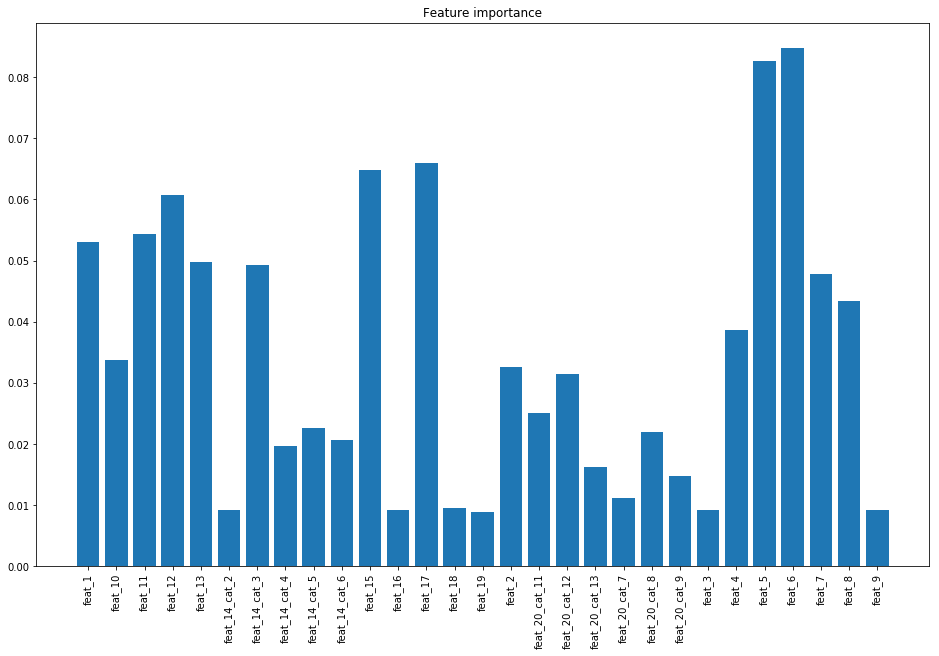

In [13]:
plt.figure(figsize=(16,10))
plt.bar(X.columns.tolist(),rf.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importance")
plt.show()

In [14]:
keep_vars = X2.columns.tolist()
print(keep_vars)

['feat_14_cat_2', 'feat_14_cat_3', 'feat_14_cat_4', 'feat_14_cat_6', 'feat_20_cat_11', 'feat_20_cat_12', 'feat_20_cat_13', 'feat_20_cat_7', 'feat_20_cat_8', 'feat_20_cat_9', 'feat_1', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_11', 'feat_12']


In [15]:
keep_vars += ['feat_13','feat_15','feat_17']
X2 = X[keep_vars]
X2.head()

,feat_14_cat_2,feat_14_cat_3,feat_14_cat_4,feat_14_cat_6,feat_20_cat_11,feat_20_cat_12,feat_20_cat_13,feat_20_cat_7,feat_20_cat_8,feat_20_cat_9,feat_1,feat_5,feat_6,feat_7,feat_8,feat_11,feat_12,feat_13,feat_15,feat_17
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.570534,0.452290,0.455577,0.614444,0.395305,0.597305,0.605692,0.597305,0.514015,0.431000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428027,0.429476,0.561257,0.500088,0.392931,0.734307,0.472253,0.734307,0.378954,0.372149
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529440,0.538690,0.474761,0.398760,0.473483,0.425333,0.392396,0.425333,0.426907,0.555191
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.504725,0.380703,0.551903,0.480093,0.357370,0.529783,0.582431,0.529783,0.405525,0.378955
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.565663,0.538854,0.501510,0.413194,0.394315,0.676111,0.648062,0.676111,0.416461,0.358631


I run Random Forest on the whole dataset to analyze features importance. I can see that some features, which were dropped using Lasso Regression are important according to this model. That's why I decide to add 3 features.

# Correlation

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB055AB4A8>,
      dtype=object)

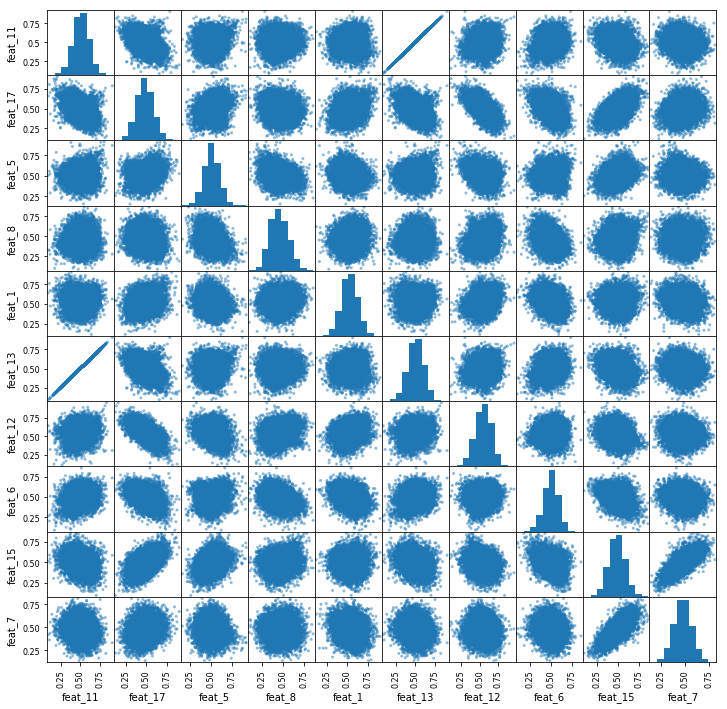

In [16]:
df_num = X2[list(set(keep_n_vars).intersection(X2.columns))]
df_num_sample = df_num.sample(10000)
pd.scatter_matrix(df_num_sample,figsize=(12, 12))

Double check if there are highly correlated features. I'm using a sample because it takes too much time to plot all observations. Now I can see, why lasso regression dropped some features - they are correlated with others.

- feat_13 is highly correlated with feat_11
- feat_15 and feat_17 is correlated with feat_7

In [17]:
keep_vars.remove("feat_13")
keep_vars.remove("feat_7")
X2 = X[keep_vars]
X2.head()

,feat_14_cat_2,feat_14_cat_3,feat_14_cat_4,feat_14_cat_6,feat_20_cat_11,feat_20_cat_12,feat_20_cat_13,feat_20_cat_7,feat_20_cat_8,feat_20_cat_9,feat_1,feat_5,feat_6,feat_8,feat_11,feat_12,feat_15,feat_17
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.570534,0.452290,0.455577,0.395305,0.597305,0.605692,0.514015,0.431000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428027,0.429476,0.561257,0.392931,0.734307,0.472253,0.378954,0.372149
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529440,0.538690,0.474761,0.473483,0.425333,0.392396,0.426907,0.555191
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.504725,0.380703,0.551903,0.357370,0.529783,0.582431,0.405525,0.378955
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.565663,0.538854,0.501510,0.394315,0.676111,0.648062,0.416461,0.358631


According to Random Forest feat_15 and feat_17 are more important than feat_7, that's why I decided to drop feat_7 instead.

# Outliers

In [18]:
df_num = X2[list(set(keep_n_vars).intersection(X2.columns))]
def get_outliers(df):
#     df = df.reset_index(drop=True)
    outliers_list=[]
    for col in df.columns:
        mean = np.mean(df[col])
        std = np.std(df[col])
        
        outliers = list(df[(df[col]>(mean+3*std)) | (df[col]<(mean-3*std))].index.values)
        outliers_list+=outliers
        
    return outliers_list
    
outliers = get_outliers(df_num)
print(len(outliers))

15821


I'm deleting 15821 rows, which are outliers. I'm using 3 standard deviations rule.

In [19]:
X = X2[~(X2.index.isin(outliers))]
y = y[~(y.index.isin(outliers))]
# del X2

In [20]:
X.shape

(551113, 18)

In [21]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# pca.fit(X)
# X = pca.fit_transform(X)
# X.shape

I've tried running models after dimensionality reduction using PCA, with different numbers of components. Results weren't better or only slightly better so I've decided not to use Principal Component Analysis.

# Predictive modelling

In [22]:
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

I decide to create 3 datasets (train, validation, test) to have control of choosing the cutoff. It's important because my goal is to predict "ones" as good as I can. Firstly I want to check if it this approach will allow me to get stable results. Only if it isn't the case I will implement cross-validation.

In [23]:
def model_score(probs,y_val):
    roc_auc = []
    accuracies = []
    f1 = []
    xs = []
    recall=[]
    for x in range(5,95,5):
        xs.append(x/100)
        cutoff = x/100
        predictions = [int(p>cutoff) for p in probs]
        roc_auc.append(roc_auc_score(y_val, predictions))
        f1.append(f1_score(y_val, predictions))
        recall.append(recall_score(y_val, predictions))
        accuracies.append(accuracy_score(y_val, predictions))

      
    plt.plot(xs,f1, label='f1_score',c="blue")
    plt.plot(xs,accuracies, label="accuracy",c="orange")
    plt.plot(xs,recall, label="recall score",c="green")
    plt.legend()
    plt.show()

Function, which allows me to select a cutoff. 

In [24]:
def roc_curve(probs,y_test,cutoff,train_acc=False):  
    predictions = [int(p>cutoff) for p in probs]
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,probs)
    roc = metrics.auc(fpr, tpr)
    lw=2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("ROC Curve")
    plt.show()
    
    print(confusion_matrix(y_test, predictions,labels = [1,0]))
    if train_acc==False:
        print("Accuracy: %.2f%% (test)" % (accuracy * 100.0))
    else:
        print("Accuracy: %.2f%% (test)" % (accuracy * 100.0) + " vs %.2f%% (train)" % (train_acc * 100.0))
    print("Recall score: %.2f%%" % (recall * 100.0))

Function to evaluate the model on test set.

# Logistic

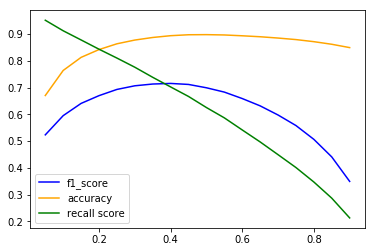

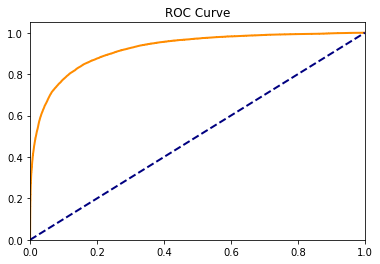

[[11948  3520]
 [ 6549 60650]]
Accuracy: 87.82% (test) vs 89.73% (train)
Recall score: 77.24%


In [25]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)

train_acc = logistic.score(X_train,y_train)

probs = logistic.predict_proba(X_val)[:,1]
model_score(probs,y_val)
probs = logistic.predict_proba(X_test)[:,1]
roc_curve(probs,y_test,0.3,train_acc)

The accuracy of logistic regression is pretty good, but recall value is not. It means that, based only on this model there too many False Negatives. Accuracy on the train set is similar to accuracy on the test set. Therefore I can assume that model isn't overfitting.

# Neural Network

In [26]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Keras doesn't have f1_score metric implemented. That's why I'm using this function.

In [27]:
dim = X_train.shape[1]
nn = Sequential()
nn.add(Dense(40, input_dim=dim, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(20, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(1, activation='sigmoid'))


nn.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=[f1])


#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = nn.fit(X_train, y_train
                 ,epochs=150
                 ,batch_size=10000
                 ,verbose=0
                 )

I'm using dropout regularization to prevent overfitting, but it isn't necessary.

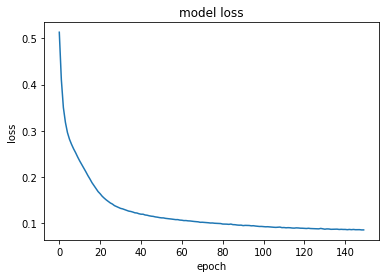

In [28]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Learning curve shows that there is not much improvement following new epochs.

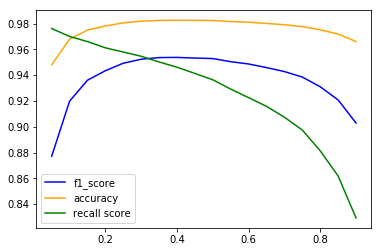

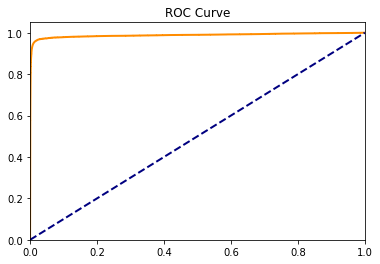

[[14761   707]
 [  849 66350]]
Accuracy: 98.12% (test)
Recall score: 95.43%


In [29]:
probs = nn.predict(X_val)
model_score(probs,y_val)
probs = nn.predict(X_test)
roc_curve(probs,y_test,0.3)

Neural network model is much better than logistic regression. Both accuracy and recall are very good. With this model I'm able to predict correctly almost 95% of sick patients.

# Random Forest

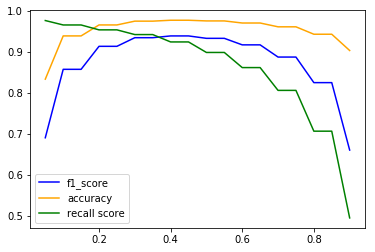

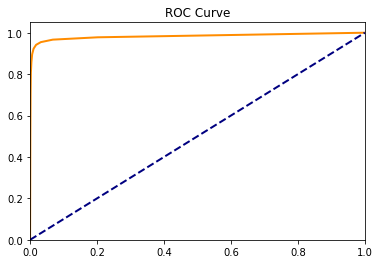

[[14765   703]
 [ 2160 65039]]
Accuracy: 96.54% (test) vs 99.76% (train)
Recall score: 95.46%


In [30]:
rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
#     verbose=1
)
rf.fit(X_train, y_train)

train_acc = rf.score(X_train,y_train)

probs = rf.predict_proba(X_val)[:,1]
model_score(probs,y_val)
probs = rf.predict_proba(X_test)[:,1]
roc_curve(probs,y_test,0.25,train_acc)

Random Forest scores are very similar to those obtained, using a neural network.

# Naive Bayes

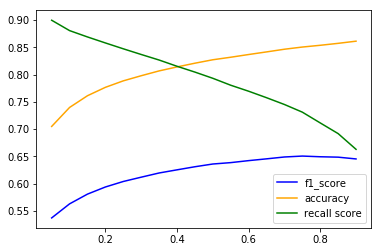

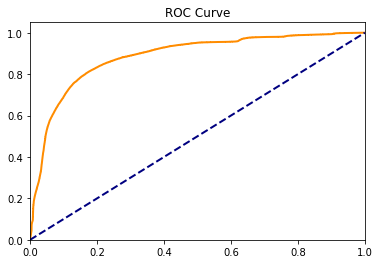

[[12868  2600]
 [13344 53855]]
Accuracy: 80.71% (test) vs 82.70% (train)
Recall score: 83.19%


In [31]:
nb = GaussianNB()
nb.fit(X_train, y_train)

train_acc = nb.score(X_train,y_train)

probs = nb.predict_proba(X_val)[:, 1]
model_score(probs,y_val)
probs = nb.predict_proba(X_test)[:, 1]
roc_curve(probs,y_test,0.35, train_acc)

Naive Bayes model has similar recall to Logistic Regression model, but much worse accuracy. On the test set there are more False Positives than True Postives.

# XGBoost

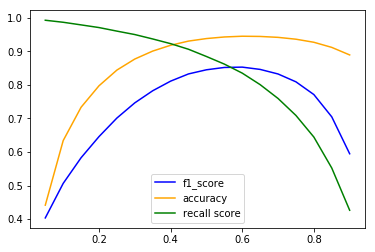

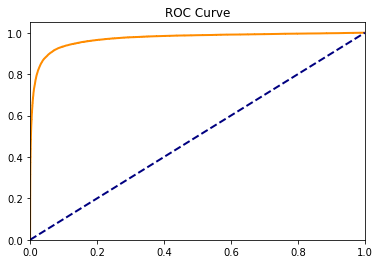

[[14297  1171]
 [ 5541 61658]]
Accuracy: 91.88% (test)
Recall score: 92.43%


In [32]:
# !pip install xgboost
# I don't think you can install xgboost using pip, but I put it here just to point out that it must be installed
from xgboost import  XGBClassifier
xgb = XGBClassifier(objective='binary:logistic',eval_metric = 'auc',scale_pos_weight=3)
xgb.fit(X_train, y_train)

probs = xgb.predict_proba(X_val)[:,1]
model_score(probs,y_val)
probs = xgb.predict_proba(X_test)[:,1]
roc_curve(probs,y_test,0.4)

Because my main objective is to increase recall score while having high accuracy I'm focusing on tuning scale_pos_weight parameter. The difference between my model and the default one isn't huge, but increasing weight for "ones" helps me getting less "False Negatives". Changing other hyperparameters (like min_child_weight or learning_rate) doesn't really have an impact on the model. I've also tried changing gamma, but there is no really need for regularization. 

Results are slightly worse than random forest and neural network.

# Ensemble

In [33]:
models = {
          'nb': {'model':nb,'cutoff':0.35},
          'nn': {'model':nn,'cutoff':0.3},
          'random forest': {'model':rf,'cutoff':0.25},
          'xgb': {'model':xgb,'cutoff':0.4},
          'logistic': {'model':logistic,'cutoff':0.3},
          }
def predict(model_list,X_val,X_test):
    cols = list()
    P_val = np.zeros((y_test.shape[0], len(model_list)))
    P_val = pd.DataFrame(P_val)
    
    P_test = np.zeros((y_test.shape[0], len(model_list)))
    P_test = pd.DataFrame(P_test)

    Y_hat = np.zeros((y_test.shape[0], len(model_list)))
    Y_hat = pd.DataFrame(Y_hat)
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        if name=='nn':
            probs = m['model'].predict_proba(X_val)
            P_val.iloc[:, i] = probs
            probs = m['model'].predict_proba(X_test)
            P_test.iloc[:, i] = probs
            Y_hat.iloc[:, i] = [int(p>m['cutoff']) for p in probs]
        else:
            probs = m['model'].predict_proba(X_val)[:, 1]
            P_val.iloc[:, i] = probs
            probs = m['model'].predict_proba(X_test)[:, 1]
            P_test.iloc[:, i] = probs
            Y_hat.iloc[:, i] = [int(p>m['cutoff']) for p in probs]
        cols.append(name)
        print("done")

    P_val.columns = cols
    P_test.columns = cols
    Y_hat.columns = cols
    print("Done.\n")
    return P_val,P_test, Y_hat 

P_val,P_test,Y_hat = predict(models,X_val,X_test)
P_test.head()

nb... done
nn... done
random forest... done
xgb... done
logistic... done
Done.



,nb,nn,random forest,xgb,logistic
0,0.036600,0.014589,0.0,0.081077,0.035704
1,0.001278,0.042545,0.1,0.035410,0.031761
2,0.145245,0.007957,0.0,0.127672,0.091080
3,0.000089,0.001227,0.0,0.034650,0.006017
4,1.000000,0.999969,1.0,0.986792,0.997787


[MLENS] backend: threading


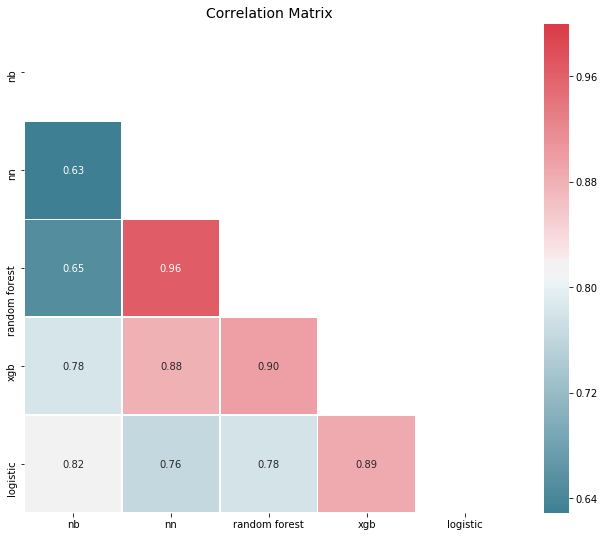

In [34]:
# !pip install mlens
from mlens.visualization import corrmat
corrmat(P_test.corr(), inflate=False)
plt.show()

Based on this correlation graph I can see that random forest and neural network errors are highly correlated. Most correlations are in the 60-80% span. It means that there is a chance that combining those models can get better results.

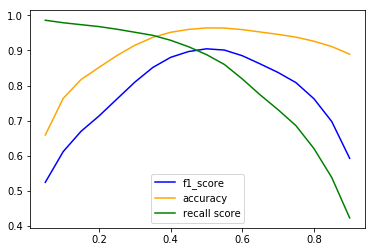

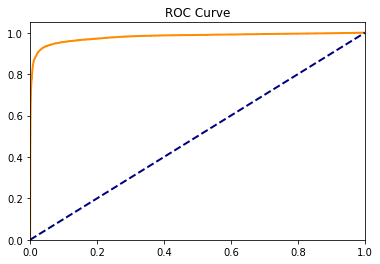

[[14387  1081]
 [ 2834 64365]]
Accuracy: 95.26% (test)
Recall score: 93.01%


In [35]:
new_probs = P_val.mean(axis=1)
model_score(new_probs,y_val)
new_probs = P_test.mean(axis=1)
roc_curve(new_probs,y_test,0.4)

I can't say for sure that combination of all models is better than random forest or neural network. Therefore I decide to select Random Forest as my final model to make the scoring process a little bit simpler.

In [36]:
X_train.columns.tolist()
print(keep_vars)

['feat_14_cat_2', 'feat_14_cat_3', 'feat_14_cat_4', 'feat_14_cat_6', 'feat_20_cat_11', 'feat_20_cat_12', 'feat_20_cat_13', 'feat_20_cat_7', 'feat_20_cat_8', 'feat_20_cat_9', 'feat_1', 'feat_5', 'feat_6', 'feat_8', 'feat_11', 'feat_12', 'feat_15', 'feat_17']


# Testing model on new data

In [37]:
keep_vars = ['feat_14_cat_2',
             'feat_14_cat_3',
             'feat_14_cat_4',
             'feat_14_cat_5',
             'feat_14_cat_6',
             'feat_20_cat_11',
             'feat_20_cat_12',
             'feat_20_cat_13',
             'feat_20_cat_7',
             'feat_20_cat_8',
             'feat_20_cat_9',
             'feat_1',
             'feat_2',
             'feat_3',
             'feat_4',
             'feat_5',
             'feat_6',
             'feat_7',
             'feat_8',
             'feat_9',
             'feat_10',
             'feat_11',
             'feat_12', 
             'feat_13', 
             'feat_15', 
             'feat_16', 
             'feat_17', 
             'feat_18',
             'feat_19']
keep_final_vars = ['feat_14_cat_2',
             'feat_14_cat_3',
             'feat_14_cat_4',
             'feat_14_cat_6',
             'feat_20_cat_11',
             'feat_20_cat_12',
             'feat_20_cat_13',
             'feat_20_cat_7',
             'feat_20_cat_8',
             'feat_20_cat_9',
             'feat_1',
             'feat_5',
             'feat_6',
             'feat_8',
             'feat_11',
             'feat_12',
             'feat_15',
             'feat_17']

def test_model(data):
    #preprocessing
    y= data["target"]
    X = pd.get_dummies(data,columns=["feat_14","feat_20"])
    X = X[keep_vars]
    np_scaled = min_max_scaler.transform(X)
    X = pd.DataFrame(np_scaled)
    X.columns = keep_vars
    X = X[keep_final_vars]
    
    #model
    
    probs = rf.predict_proba(X)[:,1]
    roc_curve(probs,y,0.25)
    
# new_data = pd.read_csv("data.csv")
# new_data = new_data.sample(100000)
# test_model(new_data)

Function to evaluate model on new data.

# Bonus

I put hyperparameters optimization as an bonus part, because it takes a lot of time to run this and in this case I don't think it's necessary.

# Hyperparameters optimization

In [38]:
from sklearn.model_selection import cross_val_score
baseline = -cross_val_score(RandomForestClassifier(), X_train, y_train, scoring='f1').mean()
baseline

-0.9295822342259532

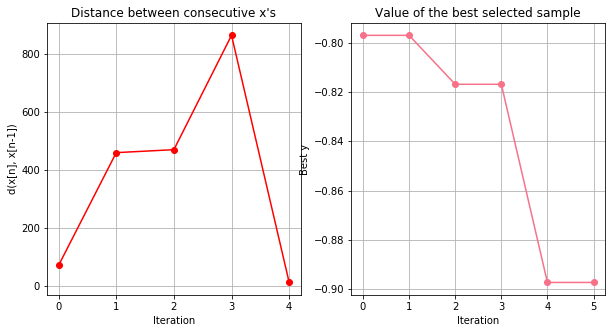

In [39]:
import GPyOpt
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                RandomForestClassifier(n_estimators =int(parameters[0]),
                              max_features=int(parameters[1]),
                              min_samples_leaf=int(parameters[2]),
                              max_depth=int(parameters[3])),
                X_train, y_train, scoring='f1').mean()

    score = np.array(score)
    return score

bounds = [
            {'name': 'n_estimators ', 'type': 'discrete', 'domain': tuple(range(2, 100))},
            {'name': 'max_features ', 'type': 'discrete', 'domain': tuple(range(2, 18))},
            {'name': 'min_samples_leaf ', 'type': 'discrete', 'domain': tuple(range(10, 1000))},
            {'name': 'max_depth  ', 'type': 'discrete', 'domain': tuple(range(3, 100))}
         ]

optimizer = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                                acquisition_type ='MPI',
                                                acquisition_par = 0.1,
                                                exact_eval=True)

max_iter = 50
max_time = 10
optimizer.run_optimization(max_iter, max_time)
optimizer.plot_convergence()

In [40]:
x_best = [int(x) for x in optimizer.X[np.argmin(optimizer.Y)]]
best_params = dict(zip([el['name'] for el in bounds], x_best))
print(best_params)
performance_boost =  baseline/np.min(optimizer.Y)
performance_boost

{'n_estimators ': 96, 'max_features ': 12, 'min_samples_leaf ': 88, 'max_depth  ': 64}


1.0360039124316016

There is no imporvement at all. Probably this algorithm needs more iterations, but it's presented here rather as an example of bayesian optimization than good soultion to this problem.

# What else can be done

I'm rather satisfied with my results, but there is always something you can do more. Here are 4 examples of things that can be done, if there is a need for improvement.

1. Numeric features can be grouped and transformed using WOE (Weight of evidence).
2. Hyperparameter optimization can be applied on all models.
3. Other models can be implemented, such as SVM or KNeighbors Classifier.
4. Ensembling models with different weights.